# **Preparation**

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Install library Sastrawi untuk processing teks bahasa Indonesia
!pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.2 MB/s eta 0:00:00


In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Install gensim
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 34.8 MB/s eta 0:00:00


# **Data Wrangling**

## **Data Gathering**

In [ ]:
# Load dataset ulasan aplikasi
# Membuat DataFrame dari hasil scrapreview
df = pd.read_csv('https://drive.google.com/uc?id=1PZkkCLpp_u5NYMW3gsmGE6loaghCy7Qq')

# Menghitung jumlah baris dan kolom dalam DataFrame
jumlah_ulasan, jumlah_kolom = df.shape

In [ ]:
# Mengambil data sebanyak 2000
app_reviews_df = df.head(2000)

## **Data Assessing**

In [ ]:
# Cek dataset ulasan seabank
app_reviews_df.head()

,content
0,good
1,enak dan mudah
2,bagus
3,mudah digunakan & cepat semua prosesnya top lah
4,sangat puas


In [ ]:
# Cek informasi dataset
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  2000 non-null   object
dtypes: object(1)
memory usage: 15.8+ KB


## **Data Cleaning**

In [ ]:
# Membuat DataFrame baru (clean_df) dengan menghapus baris yang memiliki nilai yang hilang (NaN) dari app_reviews_df
clean_df = app_reviews_df.dropna()

In [ ]:
# Menghapus baris duplikat dari DataFrame clean_df
clean_df = clean_df.drop_duplicates()

# Menghitung jumlah baris dan kolom dalam DataFrame clean_df setelah menghapus duplikat
jumlah_ulasan_setelah_hapus_duplikat, jumlah_kolom_setelah_hapus_duplikat = clean_df.shape

In [ ]:
print(f'Jumlah ulasan setelah menghapus duplikat: {jumlah_ulasan_setelah_hapus_duplikat}')
print(f'Jumlah kolom setelah menghapus duplikat: {jumlah_kolom_setelah_hapus_duplikat}')

Jumlah ulasan setelah menghapus duplikat: 1237
Jumlah kolom setelah menghapus duplikat: 1


In [ ]:
# Cek informasi data ulasan terbaru setelah cleaning
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1237 entries, 0 to 1999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  1237 non-null   object
dtypes: object(1)
memory usage: 19.3+ KB


# **Text Processing**

### **Cleaning**

In [ ]:
# Fungsi untuk menghapus huruf, angka, tanda baca, spasi, dan semacamnya
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka

    # Menghapus karakter selain huruf, angka, dan spasi (ini juga menghapus tanda baca)
    text = re.sub(r'[^\w\s]', '', text)

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    # Baris di bawah ini redundant jika baris re.sub(r'[^\w\s]', '', text) sudah ada
    # text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

### **Casefolding**

In [ ]:
# Fungsi untuk mengubah format huruf menjadi kecil
def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

### **Normalization**

In [ ]:
# Menghapus slang words pada data teks
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual",
              "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "w": "aku",
              "ama" : "sama", "lo" : "kamu"}

# Path ke file slang_indo.txt untuk menambah pembendaharaan kata
slang_file_url = 'https://drive.google.com/uc?id=1ZvezExew8-jylnahP_Nb6uG9wNCsInMD&export=download' # Tambahkan &export=download
local_file_path = 'slang_indo.txt'

!wget "{slang_file_url}" -O "{local_file_path}"

# Muat data slang dari file
try:
    with open(local_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            # Format "slang:baku" per baris
            parts = line.strip().split('\t')
            if len(parts) == 2:
                slang, baku = parts
                slangwords[slang.lower()] = baku.lower() # Tambahkan ke kamus, konversi ke lowercase
except FileNotFoundError:
    print(f"File '{local_file_path}' tidak ditemukan. Hanya menggunakan kamus bawaan.")
except Exception as e:
    print(f"Terjadi kesalahan saat membaca file '{local_file_path}': {e}")

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

--2026-02-15 14:28:44--  https://drive.google.com/uc?id=1ZvezExew8-jylnahP_Nb6uG9wNCsInMD&export=download
Resolving drive.google.com (drive.google.com)... 108.177.121.138, 108.177.121.100, 108.177.121.101, ...
Connecting to drive.google.com (drive.google.com)|108.177.121.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1ZvezExew8-jylnahP_Nb6uG9wNCsInMD&export=download [following]
--2026-02-15 14:28:44--  https://drive.usercontent.google.com/download?id=1ZvezExew8-jylnahP_Nb6uG9wNCsInMD&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 64.233.181.132, 2607:f8b0:4001:c09::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|64.233.181.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23377 (23K) [application/octet-stream]
Saving to: ‘slang_indo.txt’

slang_indo.txt      100%[===================>]  22.83K  --.-KB/

In [ ]:
print(slangwords)

{'@': 'di', 'abis': 'habis', 'wtb': 'beli', 'masi': 'masih', 'wts': 'jual', 'wtt': 'tukar', 'bgt': 'banget', 'maks': 'maksimal', 'w': 'aku', 'ama': 'sama', 'lo': 'kamu', '7an': 'tujuan', 'ababil': 'abg labil', 'acc': 'terima', 'accor': 'accord', 'ad': 'ada', 'adlah': 'adalah', 'adlh': 'adalah', 'adoh': 'aduh', 'afaik': 'as far as i know', 'aha': 'tertawa', 'ahaha': 'haha', 'aing': 'saya', 'aj': 'saja', 'aja': 'saja', 'ajep-ajep': 'dunia gemerlap', 'ajj': 'saja', 'ak': 'saya', 'aka': 'dikenal juga sebagai', 'akika': 'aku', 'akko': 'aku', 'akkoh': 'aku', 'akku': 'aku', 'akuwh': 'aku', 'akyu': 'aku', 'alay': 'norak', 'alesan': 'alasan', 'aljasa': 'asal jadi saja', 'alow': 'halo', 'ambilin': 'ambilkan', 'ambl': 'ambil', 'ancur': 'hancur', 'and': 'dan', 'anjir': 'anjing', 'anjrit': 'anjing', 'ank': 'anak', 'anter': 'antar', 'ap': 'apa', 'ap2': 'apa-apa', 'apaan': 'apa', 'apasih': 'apa sih', 'ape': 'apa', 'apes': 'sial', 'apk': 'aplikasi', 'aplot': 'unggah', 'aplikasih': 'aplikasi', 'app': '

In [ ]:
# Contoh hasil dari slang word
teks_dengan_slang = "ihh jijay gw ama lo"
teks_tanpa_slang = fix_slangwords(teks_dengan_slang)
print(teks_tanpa_slang)

ihh jijik saya sama kamu


### **Tokenizing**

In [ ]:
# Fungsi untuk tokenisasi
def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

### **Stopwords Removal**

In [ ]:
# Fungsi untuk menghapus stopwords dalam kalimat
def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

### **Stemming**

In [ ]:
# Fungsi untuk menghapus imbuhan dalam teks agar berubah menjadi bentuk dasar
def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

### **ToSentence**

In [ ]:
# Fungsi untuk mengubah daftar kata ke dalam kalimat
def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [ ]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token setelah stopword removal menjadi kalimat (untuk stemming)
clean_df['text_for_stemming'] = clean_df['text_stopword'].apply(toSentence)

# Menerapkan stemming pada teks yang sudah dalam bentuk kalimat
clean_df['text_stemmed'] = clean_df['text_for_stemming'].apply(stemmingText)

# Kolom akhir akan berisi teks yang sudah melalui semua tahapan preprocessing, termasuk stemming
clean_df['text_akhir'] = clean_df['text_stemmed']

In [ ]:
# Cek dataset review setelah di-preprocessing
clean_df.head()

,content,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_for_stemming,text_stemmed,text_akhir
0,good,good,good,bagus,[bagus],[bagus],bagus,bagus,bagus
1,enak dan mudah,enak dan mudah,enak dan mudah,enak dan mudah,"[enak, dan, mudah]","[enak, mudah]",enak mudah,enak mudah,enak mudah
2,bagus,bagus,bagus,bagus,[bagus],[bagus],bagus,bagus,bagus
3,mudah digunakan & cepat semua prosesnya top lah,mudah digunakan cepat semua prosesnya top lah,mudah digunakan cepat semua prosesnya top lah,mudah digunakan cepat semua prosesnya top lah,"[mudah, digunakan, cepat, semua, prosesnya, to...","[mudah, cepat, prosesnya, top]",mudah cepat prosesnya top,mudah cepat proses top,mudah cepat proses top
4,sangat puas,sangat puas,sangat puas,sangat puas,"[sangat, puas]",[puas],puas,puas,puas


# **Labeling**

In [ ]:
import requests
import csv
from io import StringIO

# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")

# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

In [ ]:
# Fungsi untuk menentukan polaritas sentimen dari tweet
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    # Inisialisasi skor sentimen ke 0

    for word in text:
        # Mengulangi setiap kata dalam teks

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen

    polarity=''
    # Inisialisasi variabel polaritas

    if (score > 0):
        polarity = 'positive'
        # Jika skor sentimen lebih besar atau sama dengan 0, maka polaritas adalah positif
    elif (score < 0):
        polarity = 'negative'
        # Jika skor sentimen kurang dari 0, maka polaritas adalah negatif

    else:
        polarity = 'neutral'
        # Jika tidak keduanya, maka netral

    return score, polarity
    # Mengembalikan skor sentimen dan polaritas teks

In [ ]:
# Cek hasil polaritas
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
positive    655
neutral     326
negative    256
Name: count, dtype: int64


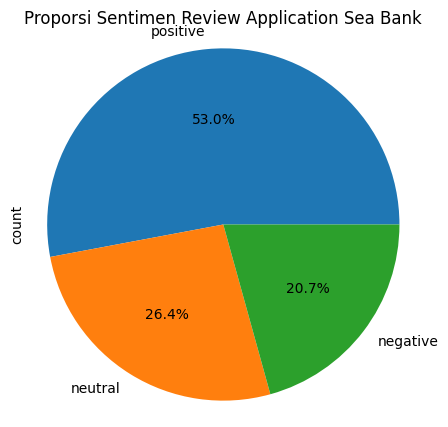

In [ ]:
# 5. Visualisasi Pie Chart proporsi sentimen

fig, ax = plt.subplots(figsize=(5,5))
counts =clean_df['polarity'].value_counts()
counts.plot.pie(autopct='%1.1f%%', ax=ax, startangle=0)
ax.set_title('Proporsi Sentimen Review Application Sea Bank')
ax.axis('equal')
plt.show()

In [ ]:
# Cek dataset review setelah diberi label dengan Lexicon
clean_df.head()

,content,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_for_stemming,text_stemmed,text_akhir,polarity_score,polarity
0,good,good,good,bagus,[bagus],[bagus],bagus,bagus,bagus,-2,negative
1,enak dan mudah,enak dan mudah,enak dan mudah,enak dan mudah,"[enak, dan, mudah]","[enak, mudah]",enak mudah,enak mudah,enak mudah,4,positive
2,bagus,bagus,bagus,bagus,[bagus],[bagus],bagus,bagus,bagus,-2,negative
3,mudah digunakan & cepat semua prosesnya top lah,mudah digunakan cepat semua prosesnya top lah,mudah digunakan cepat semua prosesnya top lah,mudah digunakan cepat semua prosesnya top lah,"[mudah, digunakan, cepat, semua, prosesnya, to...","[mudah, cepat, prosesnya, top]",mudah cepat prosesnya top,mudah cepat proses top,mudah cepat proses top,8,positive
4,sangat puas,sangat puas,sangat puas,sangat puas,"[sangat, puas]",[puas],puas,puas,puas,3,positive


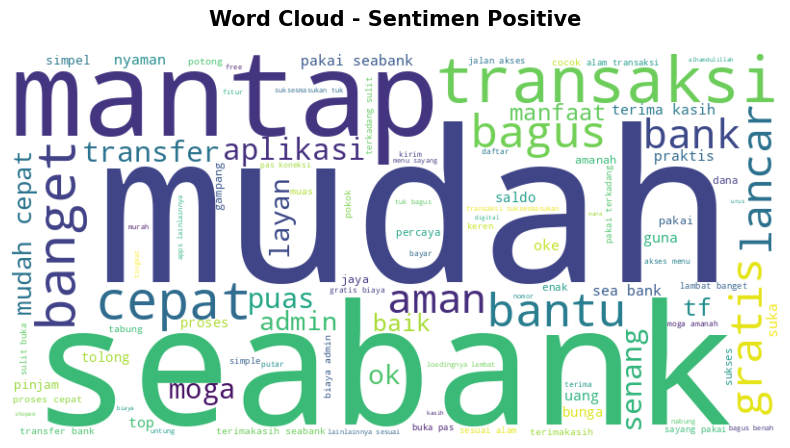

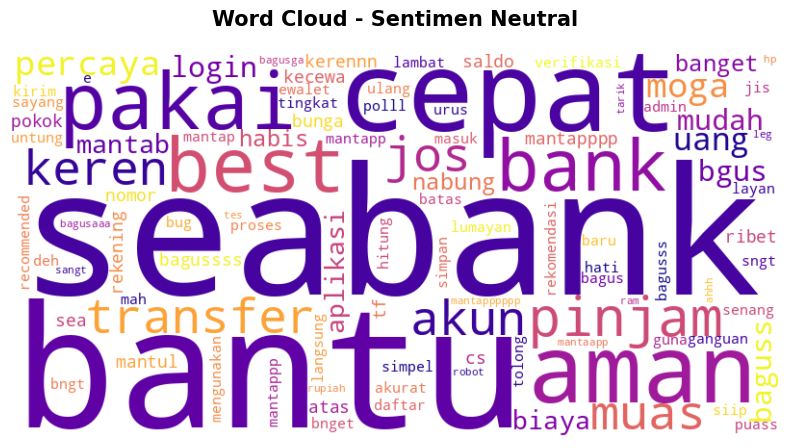

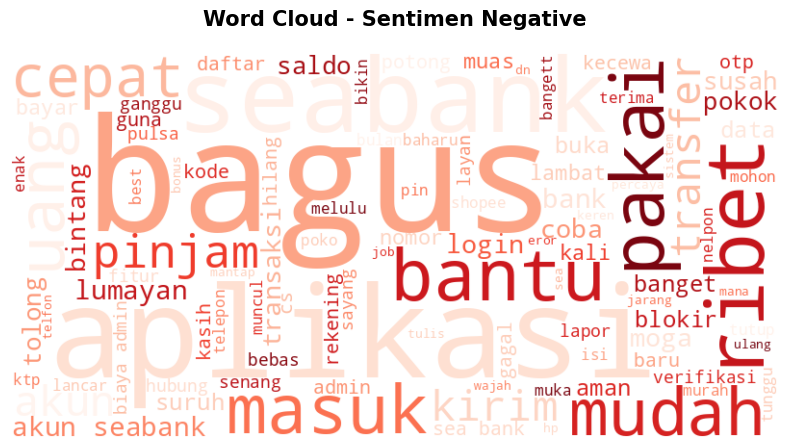

In [ ]:
# Visualisasi Wordcloud Per Sentimen


from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(sentiment_label, color_map):
    # 1. Filter data berdasarkan label sentimen
    # Menggunakan kolom 'text_akhir' yang sudah bersih
    text_data = clean_df[clean_df['polarity'] == sentiment_label]['text_akhir']

    # 2. Gabungkan semua baris teks menjadi satu string besar
    all_text = ' '.join(text_data)

    # 3. Konfigurasi dan Generate WordCloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=color_map,
        max_words=100
    ).generate(all_text)

    # 4. Tampilkan Grafik
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud - Sentimen {sentiment_label.capitalize()}', pad=20, fontsize=15, fontweight='bold')
    plt.axis('off')
    plt.show()

# Memanggil fungsi untuk setiap kategori
generate_wordcloud('positive', 'viridis')
generate_wordcloud('neutral', 'plasma')
generate_wordcloud('negative', 'Reds')

# **Feature Extraction TF-IDF + Resampling (SMOTE)**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.svm import SVC
from collections import Counter

# Penanganan potensi NameError untuk DataFrame 'clean_df'
try:
    # Memisahkan fitur (X) dan label (y) dari DataFrame yang telah dibersihkan
    X = clean_df['text_akhir']
    y = clean_df['polarity']
except NameError:
    # Pesan kesalahan jika 'clean_df' tidak ditemukan
    print("Error: DataFrame 'clean_df' tidak terdefinisi. Pastikan semua sel sebelumnya telah dieksekusi.")
    raise # Meneruskan kesalahan

# Membagi data menjadi set pelatihan (80%) dan pengujian (20%)
# test_size=0.2: 20% data untuk pengujian
# random_state=42: Menjamin reproduktifitas hasil split
# stratify=y: Menjaga proporsi kelas yang sama di X_train dan X_test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Menampilkan distribusi sentimen pada data pelatihan dan pengujian sebelum SMOTE
print("Distribusi data training sebelum SMOTE:", Counter(y_train))
print("Distribusi data testing:", Counter(y_test))

# Membangun pipeline menggunakan ImbPipeline untuk menggabungkan langkah-langkah preprocessing dan model
# SMOTE ditempatkan setelah TF-IDF untuk menghindari oversampling pada data teks mentah
pipeline_smote = ImbPipeline([
    ('tfidf', TfidfVectorizer()),                  # Langkah 1: Vektorisasi teks menggunakan TF-IDF
    ('smote', SMOTE(random_state=42)),             # Langkah 2: Oversampling kelas minoritas dengan SMOTE
    ('clf', SVC())                                 # Langkah 3: Klasifikasi menggunakan Support Vector Classifier
])

# Menentukan distribusi parameter untuk RandomizedSearchCV
# Prefiks 'tfidf__' untuk parameter TfidfVectorizer dan 'clf__' untuk parameter SVC
param_distributions_smote = {
    'tfidf__max_features': [500, 1000, 2000],  # Jumlah fitur TF-IDF maksimum
    'tfidf__ngram_range': [(1,1), (1,2)],     # Rentang N-gram (unigram atau unigram+bigram)
    'tfidf__max_df': [0.7, 0.75, 1.0],        # Ambang batas frekuensi dokumen maksimum untuk kata
    'tfidf__min_df': [1, 2, 3],               # Ambang batas frekuensi dokumen minimum untuk kata
    'clf__C': [0.1, 1, 10],                   # Parameter regulasi C untuk SVC
    'clf__kernel': ['linear', 'rbf']          # Jenis kernel untuk SVC
}

# Melakukan RandomizedSearchCV pada pipeline yang sudah termasuk SMOTE
random_search_smote = RandomizedSearchCV(
    pipeline_smote,
    param_distributions=param_distributions_smote,
    n_iter=10,         # Jumlah kombinasi parameter yang akan dicoba secara acak
    cv=10,             # Jumlah fold untuk cross-validation
    scoring='f1_macro',# Metrik evaluasi: f1-score makro untuk menangani kelas tidak seimbang
    random_state=42,   # Menjamin reproduktifitas pencarian
    n_jobs=-1          # Menggunakan semua core CPU yang tersedia
)

# Menjalankan RandomizedSearchCV pada data training
# SMOTE akan otomatis dijalankan di setiap fold CV pada subset training
print("\nMelakukan RandomizedSearchCV dengan SMOTE di dalam pipeline...")
random_search_smote.fit(X_train, y_train)

# Menampilkan hasil terbaik dari RandomizedSearchCV
print("\nHasil RandomizedSearchCV dengan SMOTE:")
print(f"Best parameters: {random_search_smote.best_params_}")
print(f"Best score (f1_macro): {random_search_smote.best_score_:.4f}")
print("-" * 40)

# Mengakses model terbaik setelah proses fitting selesai
best_pipeline = random_search_smote.best_estimator_

Distribusi data training sebelum SMOTE: Counter({'positive': 524, 'neutral': 260, 'negative': 205})
Distribusi data testing: Counter({'positive': 131, 'neutral': 66, 'negative': 51})

Melakukan RandomizedSearchCV dengan SMOTE di dalam pipeline...

Hasil RandomizedSearchCV dengan SMOTE:
Best parameters: {'tfidf__ngram_range': (1, 1), 'tfidf__min_df': 1, 'tfidf__max_features': 500, 'tfidf__max_df': 0.7, 'clf__kernel': 'linear', 'clf__C': 1}
Best score (f1_macro): 0.8519
----------------------------------------


In [ ]:
#CEK PROPORSI SETELAH DI SMOTE
from collections import Counter

# Ambil pipeline terbaik dari RandomizedSearchCV
best_model_smote = random_search_smote.best_estimator_

# Ambil kembali TF-IDF dari pipeline
tfidf = best_model_smote.named_steps['tfidf']
X_train_tfidf = tfidf.fit_transform(X_train)
# X_test_tfidf = tfidf.transform(X_test)


# Ambil kembali SMOTE dari pipeline
smote = best_model_smote.named_steps['smote']
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Hitung proporsi kelas setelah SMOTE
after_smote_counts = Counter(y_train_resampled)
total_samples = sum(after_smote_counts.values())

print("Proporsi Kelas Setelah SMOTE (Data Training):")
for label, count in after_smote_counts.items():
    percentage = (count / total_samples) * 100
    print(f"{label}: {count} data ({percentage:.2f}%)")

Proporsi Kelas Setelah SMOTE (Data Training):
positive: 524 data (33.33%)
neutral: 524 data (33.33%)
negative: 524 data (33.33%)


Distribusi sebelum SMOTE: Counter({'positive': 524, 'neutral': 260, 'negative': 205})
Distribusi sesudah SMOTE: Counter({'positive': 524, 'neutral': 524, 'negative': 524})


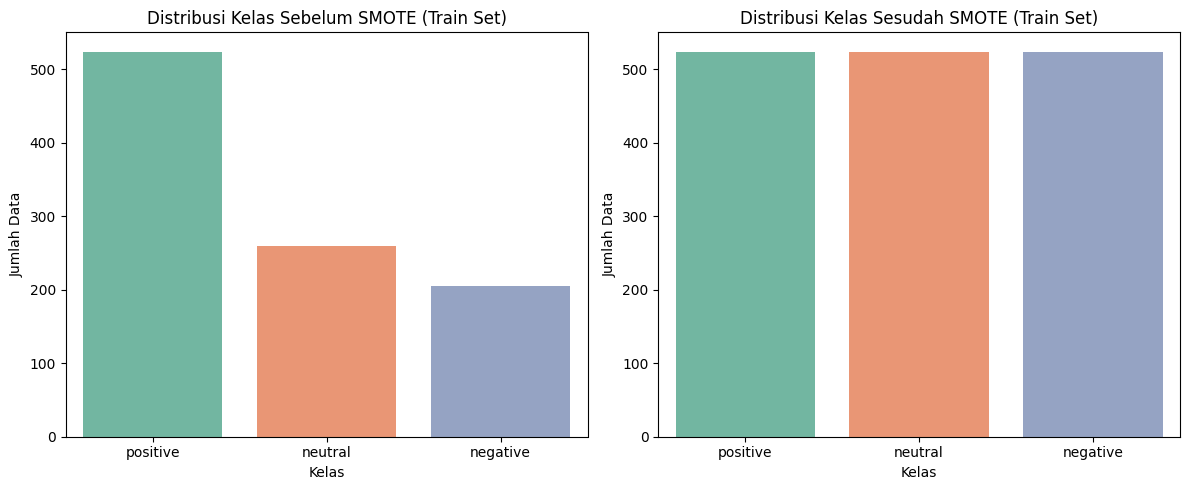

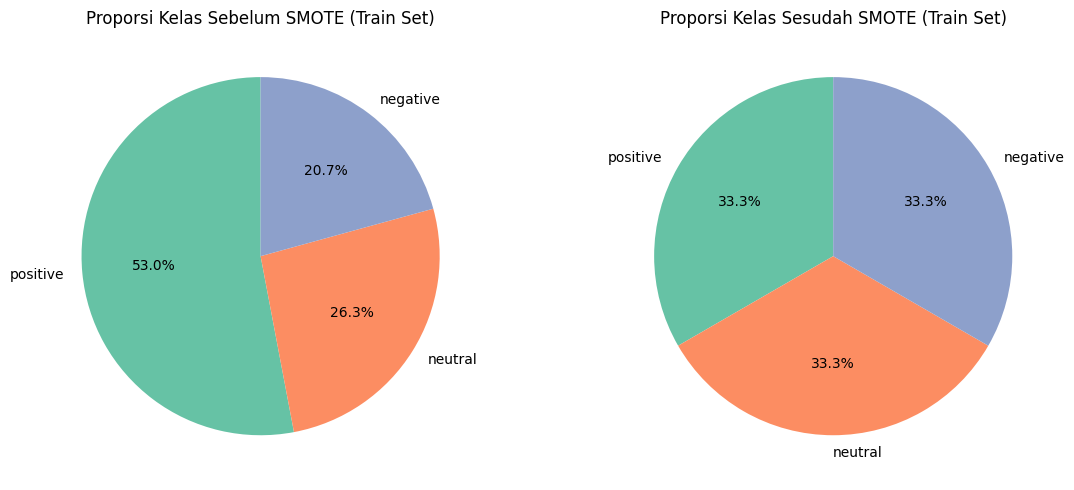

In [ ]:
from collections import Counter


# Ambil kembali hasil SMOTE dari pipeline terbaik
best_model_smote = random_search_smote.best_estimator_

# TF-IDF dari pipeline
tfidf = best_model_smote.named_steps['tfidf']
X_train_tfidf = tfidf.fit_transform(X_train)

# SMOTE dari pipeline
smote = best_model_smote.named_steps['smote']
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)


# Hitung distribusi sebelum & sesudah SMOTE
before_counts = Counter(y_train)
after_counts = Counter(y_train_resampled)

print("Distribusi sebelum SMOTE:", before_counts)
print("Distribusi sesudah SMOTE:", after_counts)


# Bar Chart
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.barplot(
    x=list(before_counts.keys()),
    y=list(before_counts.values()),
    ax=axes[0],
    palette="Set2"
)
axes[0].set_title("Distribusi Kelas Sebelum SMOTE (Train Set)")
axes[0].set_xlabel("Kelas")
axes[0].set_ylabel("Jumlah Data")

sns.barplot(
    x=list(after_counts.keys()),
    y=list(after_counts.values()),
    ax=axes[1],
    palette="Set2"
)
axes[1].set_title("Distribusi Kelas Sesudah SMOTE (Train Set)")
axes[1].set_xlabel("Kelas")
axes[1].set_ylabel("Jumlah Data")

plt.tight_layout()
plt.show()


# Pie Chart
fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].pie(
    before_counts.values(),
    labels=before_counts.keys(),
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("Set2")
)
axes[0].set_title("Proporsi Kelas Sebelum SMOTE (Train Set)")

axes[1].pie(
    after_counts.values(),
    labels=after_counts.keys(),
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("Set2")
)
axes[1].set_title("Proporsi Kelas Sesudah SMOTE (Train Set)")

plt.tight_layout()
plt.show()

# **Modeling Classification SVM atau SVC**



--- Hasil Evaluasi Model SVC (Bigram Optimized) ---
Akurasi Latih (Train) : 0.9444
Akurasi Uji (Test)   : 0.8750



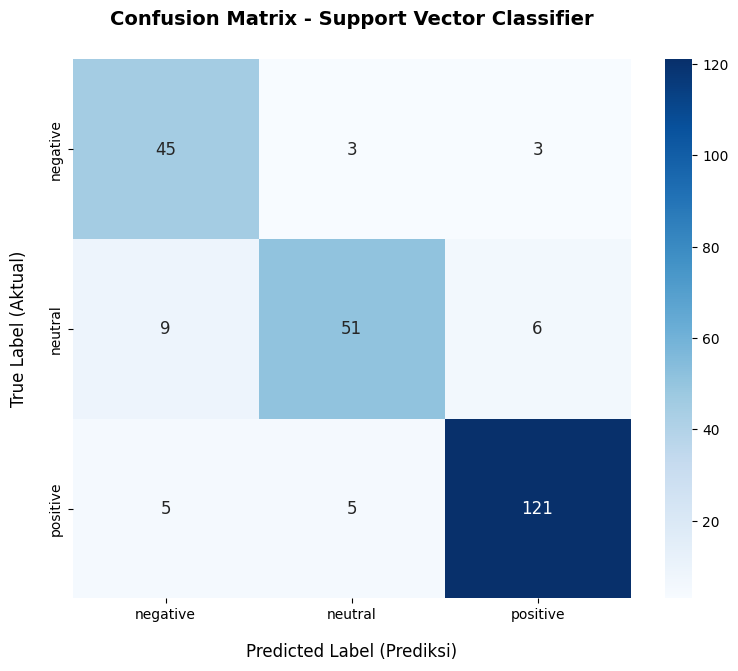


Classification Report (Data Test):
              precision    recall  f1-score   support

    negative       0.76      0.88      0.82        51
     neutral       0.86      0.77      0.82        66
    positive       0.93      0.92      0.93       131

    accuracy                           0.88       248
   macro avg       0.85      0.86      0.85       248
weighted avg       0.88      0.88      0.88       248



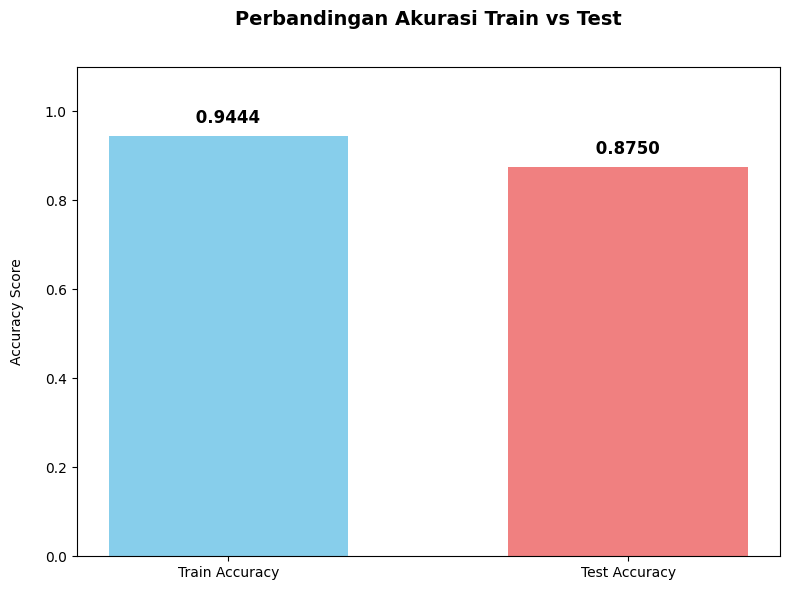

In [ ]:
# EVALUASI MODEL (MODELING & CLASSIFICATION)


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# 1. MEMANGGIL MODEL TERBAIK
# Mengambil estimator terbaik hasil dari proses RandomizedSearchCV (yang sudah dioptimasi Bigram)
model_terbaik = random_search_smote.best_estimator_

# 2. PENYIAPAN DATA (RE-SPLITTING)
try:
    X_original_text = clean_df['text_akhir']
    y_original_labels = clean_df['polarity']

    # Split data kembali untuk memastikan evaluasi dilakukan pada data yang tepat
    X_train, X_test, y_train, y_test = train_test_split(
        X_original_text,
        y_original_labels,
        test_size=0.2,
        random_state=42,
        stratify=y_original_labels
    )
except NameError:
    print("Error: DataFrame 'clean_df' tidak ditemukan.")
    raise

# 3. PROSES PREDIKSI
# Model terbaik secara otomatis mengolah teks mentah menjadi Bigram TF-IDF
y_pred_train_svc = model_terbaik.predict(X_train)
y_pred_test_svc = model_terbaik.predict(X_test)

# 4. EVALUASI AKURASI
accuracy_train_svc = accuracy_score(y_train, y_pred_train_svc)
accuracy_test_svc = accuracy_score(y_test, y_pred_test_svc)

print(f"--- Hasil Evaluasi Model SVC (Bigram Optimized) ---")
print(f"Akurasi Latih (Train) : {accuracy_train_svc:.4f}")
print(f"Akurasi Uji (Test)   : {accuracy_test_svc:.4f}\n")

# 5. VISUALISASI CONFUSION MATRIX
labels = sorted(y_test.unique())
cm = confusion_matrix(y_test, y_pred_test_svc, labels=labels)

plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            annot_kws={"size": 12})

plt.title('Confusion Matrix - Support Vector Classifier', pad=25, fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label (Prediksi)', labelpad=15, fontsize=12)
plt.ylabel('True Label (Aktual)', labelpad=15, fontsize=12)
plt.show()

# 6. CLASSIFICATION REPORT
print("\nClassification Report (Data Test):")
print(classification_report(y_test, y_pred_test_svc, target_names=labels))

# 7. BAR CHART PERBANDINGAN AKURASI
labels_accuracy = ['Train Accuracy', 'Test Accuracy']
values_accuracy = [accuracy_train_svc, accuracy_test_svc]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels_accuracy, values_accuracy, color=['skyblue', 'lightcoral'], width=0.6)

plt.ylim(0, 1.1)
plt.title('Perbandingan Akurasi Train vs Test', pad=30, fontsize=14, fontweight='bold')
plt.ylabel('Accuracy Score', labelpad=15)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02,
             f' {yval:.4f} ',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

#**Simpan Hasil Model SVM dengan Joblib**

In [ ]:
import joblib

# Simpan model Support Vector Classifier
joblib.dump(model_terbaik, 'svc_model.joblib')

print("Model SVC dan TF-IDF Vectorizer telah berhasil disimpan.")

Model SVC dan TF-IDF Vectorizer telah berhasil disimpan.
